In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers==2.1.1
!pip install -q torch

     |████████████████████████████████| 317kB 8.1MB/s 
     |████████████████████████████████| 1.2MB 50.4MB/s 
     |████████████████████████████████| 901kB 48.2MB/s 
     |████████████████████████████████| 133kB 49.0MB/s 
     |████████████████████████████████| 7.7MB 48.8MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
ERROR: botocore 1.20.106 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

#Sentiment Analyzer

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [ ]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [ ]:
model_type = 'roberta'
pretrained_model_name = 'roberta-base'

model_class, tokenizer_class, config_class = RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

pad_idx = transformer_tokenizer.pad_token_id

100%|██████████| 456318/456318 [00:00<00:00, 1358051.84B/s]


In [ ]:
path = '/content/drive/MyDrive/Internship Dataset'
learner = load_learner(path, 'transformer.pkl')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.normalization.LayerNorm' has changed. you can retrieve the original source code by accessing the object's source att

In [ ]:
def predict_sentiment(text):
  sentiment = learner.predict(text)[1].item()
  return sentiment

def sentiment_label (Sentiment):
   if Sentiment == 2:
       return "positive"
   elif Sentiment == 0:
       return "negative"
   else :
       return "neutral"

In [ ]:
DATA_ROOT = Path("..") / '/content/drive/MyDrive/Internship Dataset/Sentiment Analyzer/India_Dataset.csv'
predictions_test = pd.read_csv(DATA_ROOT)

predictions_test['Prediction'] = predictions_test['full_text'].apply(predict_sentiment)
predictions_test['Prediction_text'] = predictions_test['Prediction'].apply(sentiment_label)
class_names = ['negative','positive','neutral']

In [ ]:
predictions_test.head()

,Unnamed: 0,id,full_text,longitude,latitude,Sentiment,Prediction,Prediction_text
0,0,1.255020e+18,#HelloSuratCity\n\nThree districts of Gujarat ...,72.830000,21.170000,positive,2,positive
1,1,1.256540e+18,Assam to impose curfew in the state from 6 pm ...,91.770000,26.140000,neutral,1,neutral
2,2,1.258950e+18,Hats off the police department working on COVI...,80.394659,16.302038,neutral,1,neutral
3,3,1.263220e+18,Late night 3 new Covid-19 patients were confir...,91.591310,26.104520,positive,2,positive
4,4,1.270220e+18,"In the view of the COVID-19 crisis, the Indian...",77.209690,28.610260,positive,1,neutral


In [ ]:
print(classification_report(predictions_test['Sentiment'], predictions_test['Prediction_text'], target_names=class_names))

              precision    recall  f1-score   support

    negative       0.74      0.68      0.71       569
    positive       0.83      0.90      0.86      1335
     neutral       0.91      0.89      0.90      2256

    accuracy                           0.86      4160
   macro avg       0.83      0.82      0.82      4160
weighted avg       0.86      0.86      0.86      4160



In [ ]:
cf = confusion_matrix(predictions_test['Sentiment'],predictions_test['Prediction_text'])

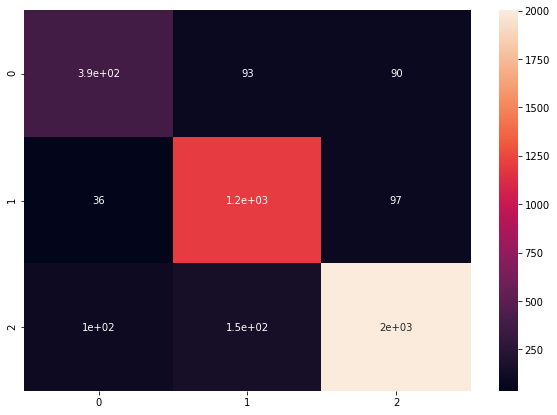

In [ ]:
#Plotting the Confusion matrix using Seaborn Library
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize = (10,7))
sn.heatmap(cf,annot=True)

#Real-Time Twitter Scrapper

In [ ]:
#Defining functions for Cleaning and Normalization of Data
import re
import string
def replace_url(string): # cleaning of URL
    text = re.sub(r'http\S+', 'LINK', string)
    return text


def replace_email(text):#Cleaning of Email related text
    line = re.sub(r'[\w\.-]+@[\w\.-]+','MAIL',str(text))
    return "".join(line)

def rep(text):#cleaning of non standard words
    grp = text.group(0)
    if len(grp) > 3:
        return grp[0:2]
    else:
        return grp# can change the value here on repetition
def unique_char(rep,sentence):
    convert = re.sub(r'(\w)\1+', rep, sentence) 
    return convert

def find_dollar(text):#Finding the dollar sign in the text
    line=re.sub(r'\$\d+(?:\.\d+)?','PRICE',text)
    return "".join(line)

def replace_emoji(text):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text) 

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']

def clean_text(text: str) -> str:
    text = str(text)
    for punct in puncts + list(string.punctuation):
        if punct in text:
            text = text.replace(punct, f'')
    return text
   
def replace_asterisk(text):
    text = re.sub("\*", 'ABUSE ', text)
    return text

def remove_duplicates(text):
    text = re.sub(r'\b(\w+\s*)\1{1,}', '\\1', text)
    return text

def change(text):
    if(text == ''):
        return text
  #calling the subfunctions in the cleaning function
    text = replace_email(text)
    text = replace_url(text)
    text = unique_char(rep,text)
    text = replace_asterisk(text)
    text = remove_duplicates(text)
    text = clean_text(text)
    return text

In [ ]:
    # Import libraries
from tweepy import OAuthHandler
#from tweepy.streaming import StreamListener
import tweepy
import csv
import pandas as pd
#import re
#from textblob import TextBlob
#import string
#import preprocessor as p
#import os
import time

# Twitter credentials
consumer_key = '8AO6OU5ubyi4XO47b1C7Sjdlz'
consumer_secret = 'FS1usPrfPolvjLXbwGka5N8TWkOZhUsdxGmmTwuO016koesUSt'
access_key = '1151573806680592384-OUFeUtpsRFZM6jQxl1AG99NEjlY0Kt'
access_secret = 'KKHmkHkDGVaDof8XK4fKKI52DmNl4vZlaXnx85WRfd4Lr'

# Pass your twitter credentials to tweepy via its OAuthHandler
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

def extract_tweets(search_words,date_since,numTweets):
  return(tweepy.Cursor(api.search, q=search_words, lang="en", since=date_since, tweet_mode='extended').items(numTweets))


In [ ]:
def scraptweets(search_words, date_since, numTweets, numRuns):
    # Define a pandas dataframe to store the date:
    db_tweets = pd.DataFrame(columns = ['username', 'acctdesc', 'location', 'following', 'followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts', 'retweetcount', 'text', 'hashtags'])
    #db_tweets = pd.DataFrame()

    for i in range(numRuns):

        tweets = extract_tweets(search_words,date_since,numTweets)
        # Store these tweets into a python list
        tweet_list = [tweet for tweet in tweets]
        print(len(tweet_list))
        noTweets = 0

        for tweet in tweet_list:
            username = tweet.user.screen_name
            acctdesc = tweet.user.description
            location = tweet.user.location
            following = tweet.user.friends_count
            followers = tweet.user.followers_count
            totaltweets = tweet.user.statuses_count
            usercreatedts = tweet.user.created_at
            tweetcreatedts = tweet.created_at
            retweetcount = tweet.retweet_count
            hashtags = tweet.entities['hashtags']
            lst=[]
            for h in hashtags:
                lst.append(h['text'])
            try:
                text = tweet.retweeted_status.full_text
            except AttributeError:  # Not a Retweet
                text = tweet.full_text

            itweet = [username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,lst]
            db_tweets.loc[len(db_tweets)] = itweet

            noTweets += 1
            print(noTweets)

            #filename = "tweets.csv"
            #with open(filename, "a", newline='') as fp:
             #   wr = csv.writer(fp, dialect='excel')
              #  wr.writerow(itweet)

        print('no. of tweets scraped for run {} is {}'.format(i + 1, noTweets))
        if i+1 != numRuns:
            time.sleep(920)

        filename = "/content/drive/MyDrive/Internship Dataset/Real-Time Data/tweets.csv"
        db_tweets['text'] = db_tweets['text'].apply(change)
        db_tweets = db_tweets[['tweetcreatedts', 'retweetcount', 'text']]
        # Store dataframe in csv with creation date timestamp
        db_tweets.to_csv(filename, index = False)

In [ ]:
# Initialise these variables:

search_words = "#India AND #COVID-19"
date_since = "2020-04-29"
#date_until = "2020-05-01"
numTweets = 2500
numRuns = 1
# Call the function scraptweets
program_start = time.time()
scraptweets(search_words, date_since, numTweets, numRuns)
program_end = time.time()
print('Scraping has completed!')
print('Total time taken to scrap is {} minutes.'.format(round(program_end - program_start)/60, 2))

2500
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276

#Real-Time Data Analysis

In [ ]:
path = '/content/drive/MyDrive/Internship Dataset/Real-Time Data/tweets.csv'
predictions = pd.read_csv(path)

predictions['Prediction'] = predictions['text'].apply(predict_sentiment)
predictions['Prediction'] = predictions['Prediction'].apply(sentiment_label)
class_names = ['negative','positive','neutral']

In [ ]:
predictions.head(10)

,tweetcreatedts,retweetcount,text,Prediction
0,2021-07-07 10:27:55,6474,India We are saddened amp disturbed by the dea...,positive
1,2021-07-07 10:27:09,6474,India We are saddened amp disturbed by the dea...,positive
2,2021-07-07 10:26:30,1,The 3rd Wave of Covid19\nIs excepted to Hit In...,neutral
3,2021-07-07 10:26:13,6474,India We are saddened amp disturbed by the dea...,positive
4,2021-07-07 10:26:00,6474,India We are saddened amp disturbed by the dea...,positive
5,2021-07-07 10:25:57,0,Speaking of sliding to the bottom to the botto...,positive
6,2021-07-07 10:25:30,6474,India We are saddened amp disturbed by the dea...,positive
7,2021-07-07 10:25:02,6474,India We are saddened amp disturbed by the dea...,positive
8,2021-07-07 10:24:26,6474,India We are saddened amp disturbed by the dea...,positive
9,2021-07-07 10:24:10,6474,India We are saddened amp disturbed by the dea...,positive


In [ ]:
predictions.rename(columns={'Prediction':'sentiment'},inplace=True)

In [ ]:
predictions.head()

,tweetcreatedts,retweetcount,text,sentiment
0,2021-07-07 10:27:55,6474,India We are saddened amp disturbed by the dea...,positive
1,2021-07-07 10:27:09,6474,India We are saddened amp disturbed by the dea...,positive
2,2021-07-07 10:26:30,1,The 3rd Wave of Covid19\nIs excepted to Hit In...,neutral
3,2021-07-07 10:26:13,6474,India We are saddened amp disturbed by the dea...,positive
4,2021-07-07 10:26:00,6474,India We are saddened amp disturbed by the dea...,positive


In [ ]:
predictions = predictions.drop(['tweetcreatedts'],axis=1)

In [ ]:
predictions.head()

,retweetcount,text,sentiment
0,6474,India We are saddened amp disturbed by the dea...,positive
1,6474,India We are saddened amp disturbed by the dea...,positive
2,1,The 3rd Wave of Covid19\nIs excepted to Hit In...,neutral
3,6474,India We are saddened amp disturbed by the dea...,positive
4,6474,India We are saddened amp disturbed by the dea...,positive


In [ ]:
predictions.to_csv('/content/drive/MyDrive/Internship Dataset/Real-Time Data/tweets.csv',index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Internship Dataset/Real-Time Data/tweets.csv')
df.head()

,retweetcount,text,sentiment
0,0,Covid19 India records 43733 new cases and 930 ...,positive
1,5,Lambda COVID19 variant believed to be more dan...,positive
2,6455,India We are saddened amp disturbed by the dea...,positive
3,6455,India We are saddened amp disturbed by the dea...,positive
4,6455,India We are saddened amp disturbed by the dea...,positive
